In [1]:
# Geometry, shapefiles and projections
import pickle
from collections import Counter
import fiona
import pyproj
import numpy as np
import pandas as pd
from numpy import inf
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt 
from shapely.geometry import shape
from shapely.geometry import Point
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

%matplotlib inline

In [2]:
# Population data - used for normalisation
country_codes = pd.read_csv('../data/raw/country-codes_csv.csv')
population = pd.read_csv('../data/raw/API_SP.POP.TOTL_DS2_en_csv_v2_10203548/API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv', skiprows=3)

# Read SHP data
shp_filename = '../data/raw/Africa_SHP/Africa.shp'
shapes = gpd.GeoDataFrame.from_file(shp_filename)
shapes.crs = {"init": "epsg:22293"}

# Read data
g_m = pd.read_csv('../data/outputs/health_groups_members.csv')
g_m.rename(index=str, inplace=True, columns={'lon':'lng'})
g_m.reset_index(inplace=True, drop=True)

# Generate a function to create a UK East/North point from Lon/Lat
wgs84 = pyproj.Proj(init = 'epsg:22293')
ukgrid = pyproj.Proj(init = 'epsg:22293')
EnPoint = lambda lng, lat : Point(*pyproj.transform(wgs84, ukgrid, lng, lat))

g_m['geometry'] = [EnPoint(g_m.loc[i, 'lng'], g_m.loc[i, 'lat']) for i in range(g_m.shape[0])]
g_m.crs = {"init": "epsg:22293"}

# Spatial join
g_m = gpd.tools.sjoin(shapes, g_m, how="right")

# Merge population information
g_m = g_m.merge(country_codes[['ISO3166-1-Alpha-2', 'ISO3166-1-Alpha-3']], left_on='country', right_on='ISO3166-1-Alpha-2')
g_m = g_m.merge(population[['Country Code', '2017']], left_on='ISO3166-1-Alpha-3', right_on='Country Code')

/Users/konstantinosstathoulopoulos/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/konstantinosstathoulopoulos/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


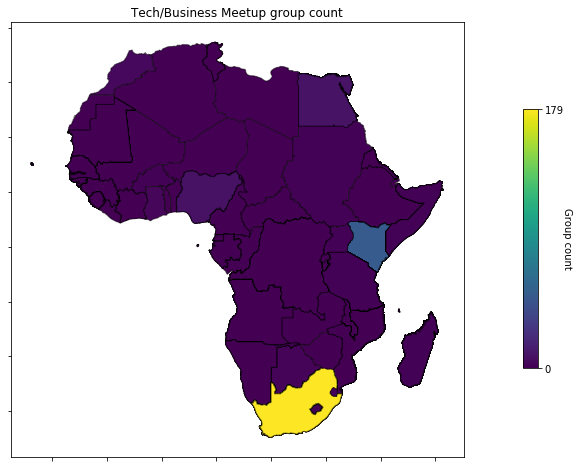

In [6]:
patches = []
color = []

fig, (ax2) = plt.subplots(ncols=1, figsize=(10,8)) 

df = g_m.drop_duplicates('group_id')
for i in shapes.CODE:
    patches.append(PolygonPatch(shapes[shapes.CODE==i]['geometry'].values[0], alpha=0.5, zorder=4))
    try:
        color.append(df[df.CODE==i].shape[0])
    except KeyError as e:
        color.append(0)

# scaled_color = np.log(color)
# scaled_color[scaled_color == -inf] = 0
p = PatchCollection(patches, cmap=plt.cm.viridis, match_original=True)
p.set_array(np.array(color))
ax2.add_collection(p)
ax2.set_title('Tech/Business Meetup group count', fontsize=12)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
# ax2.axis('off')
# ax2.set_axis_off()
ax2.axis('scaled')

cax = fig.add_axes([0.91, 0.28, 0.02, 0.45])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, spacing='proportional', ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['0', '{}'.format((max(color)))]) 

cb.set_label("Group count", labelpad=8, rotation=270)

# fig.savefig('../reports/figures/ttwa_project_count_and_map.png')

plt.show()

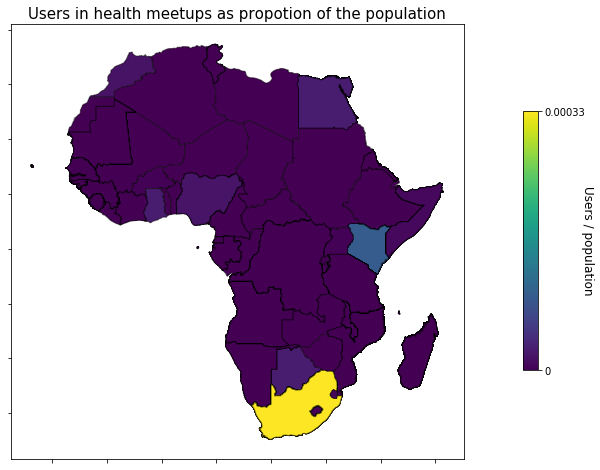

In [7]:
patches = []
color = []

fig, (ax2) = plt.subplots(ncols=1, figsize=(10,8)) 

for i in shapes.CODE:
    patches.append(PolygonPatch(shapes[shapes.CODE==i]['geometry'].values[0], alpha=0.5, zorder=4))
    try:
        color.append(g_m[g_m.CODE==i].drop_duplicates('member_id').shape[0] / g_m[g_m.CODE==i]['2017'].iloc[0])
    except KeyError as e:
        color.append(0)
    except IndexError as e:
        color.append(0)
# scaled_color = np.log(color)
# scaled_color[scaled_color == -inf] = 0
p = PatchCollection(patches, cmap=plt.cm.viridis, match_original=True)
p.set_array(np.array(color))
ax2.add_collection(p)
ax2.set_title('Users in health meetups as propotion of the population', fontsize=15)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
# ax2.axis('off')
# ax2.set_axis_off()
ax2.axis('scaled')

cax = fig.add_axes([0.91, 0.28, 0.02, 0.45])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, spacing='proportional', ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['0', '{}'.format('%.5f'%(max(color)))]) 

cb.set_label("Users / population", labelpad=8, rotation=270, size=12)

# fig.savefig('../reports/figures/ttwa_project_count_and_map.png')

plt.show()

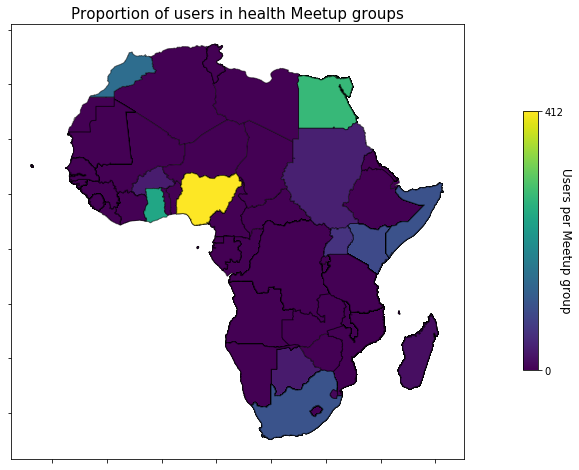

In [90]:
patches = []
color = []

fig, (ax2) = plt.subplots(ncols=1, figsize=(10,8)) 

df = g_m.drop_duplicates('group_id')
for i in shapes.CODE:
    patches.append(PolygonPatch(shapes[shapes.CODE==i]['geometry'].values[0], alpha=0.5, zorder=4))
    try:
        color.append(g_m[g_m.CODE==i].drop_duplicates('member_id').shape[0] / df[df.CODE==i].shape[0])
    except KeyError as e:
        color.append(0)
    except ZeroDivisionError as e:
        color.append(0)

# scaled_color = np.log(color)
# scaled_color[scaled_color == -inf] = 0
p = PatchCollection(patches, cmap=plt.cm.viridis, match_original=True)
p.set_array(np.array(color))
ax2.add_collection(p)
ax2.set_title('Proportion of users in health Meetup groups', fontsize=15)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
# ax2.axis('off')
# ax2.set_axis_off()
ax2.axis('scaled')

cax = fig.add_axes([0.91, 0.28, 0.02, 0.45])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, spacing='proportional', ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['0', '{}'.format(round(max(color)))]) 

cb.set_label("Users per Meetup group", labelpad=8, rotation=270, size=12)

# fig.savefig('../reports/figures/ttwa_project_count_and_map.png')

plt.show()